# Basic Transit Candidate Vetting

This tutorial introduces the core workflow for vetting transit candidates using `bittr-tess-vetter`. You will learn how to:

1. Create light curve and ephemeris objects
2. Define a transit candidate
3. Run the vetting pipeline
4. Interpret the results

## What is Transit Vetting?

Transit detection algorithms (like BLS or TLS) find periodic dips in stellar light curves. However, not all dips are real exoplanet transits. Many are caused by:

- **Eclipsing binaries**: Background or nearby binary stars whose eclipses mimic transits
- **Instrumental artifacts**: Systematic effects from the spacecraft or detector
- **Stellar variability**: Starspots, pulsations, or other astrophysical signals

Vetting checks help distinguish genuine planet candidates from false positives by examining multiple aspects of the signal.

## Setup

First, import the necessary modules. The recommended import pattern is:

In [1]:
import numpy as np
import bittr_tess_vetter.api as btv
from bittr_tess_vetter.api import LightCurve, Ephemeris, Candidate, vet_candidate

## Creating Synthetic Light Curve Data

For this tutorial, we will create synthetic data that simulates a TESS light curve with a transit signal. In real applications, you would load data from MAST or local files.

### Key Conventions

- **Time**: BTJD (Barycentric TESS Julian Date) = BJD - 2457000
- **Flux**: Normalized to median of 1.0
- **Depth**: Measured in ppm (parts per million) or fractional

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Simulate 27 days of TESS observations (one sector)
# TESS 2-minute cadence = 120 seconds
cadence_days = 2 / (24 * 60)  # 2 minutes in days
time = np.arange(1800, 1827, cadence_days)  # BTJD starting at 1800

# Create a transit signal
period = 3.5  # days
t0 = 1801.5  # BTJD of first transit
duration_hours = 2.5
depth_ppm = 1000  # 0.1% depth (1000 ppm) - typical for a hot Jupiter

# Generate the transit signal
def make_transit_signal(time, period, t0, duration_hours, depth_ppm):
    """Create a simple box-shaped transit signal."""
    flux = np.ones_like(time)
    duration_days = duration_hours / 24.0
    
    # Compute phase
    phase = ((time - t0) % period) / period
    
    # Transit occurs near phase 0 (or 1)
    half_duration_phase = (duration_days / 2) / period
    in_transit = (phase < half_duration_phase) | (phase > 1 - half_duration_phase)
    
    # Apply transit depth
    flux[in_transit] = 1.0 - depth_ppm / 1e6
    
    return flux

# Generate base flux with transit
flux_clean = make_transit_signal(time, period, t0, duration_hours, depth_ppm)

# Add realistic noise (TESS typically achieves ~60 ppm precision for bright stars)
noise_ppm = 100
flux = flux_clean + np.random.normal(0, noise_ppm / 1e6, len(time))

# Estimate flux errors (standard deviation of noise)
flux_err = np.full_like(flux, noise_ppm / 1e6)

print(f"Created light curve with {len(time)} data points")
print(f"Time range: BTJD {time[0]:.1f} to {time[-1]:.1f}")
print(f"Transit depth: {depth_ppm} ppm")
print(f"Period: {period} days")

Created light curve with 19440 data points
Time range: BTJD 1800.0 to 1827.0
Transit depth: 1000 ppm
Period: 3.5 days


### Visualize the Light Curve (Optional)

If you have matplotlib installed, you can visualize the data:

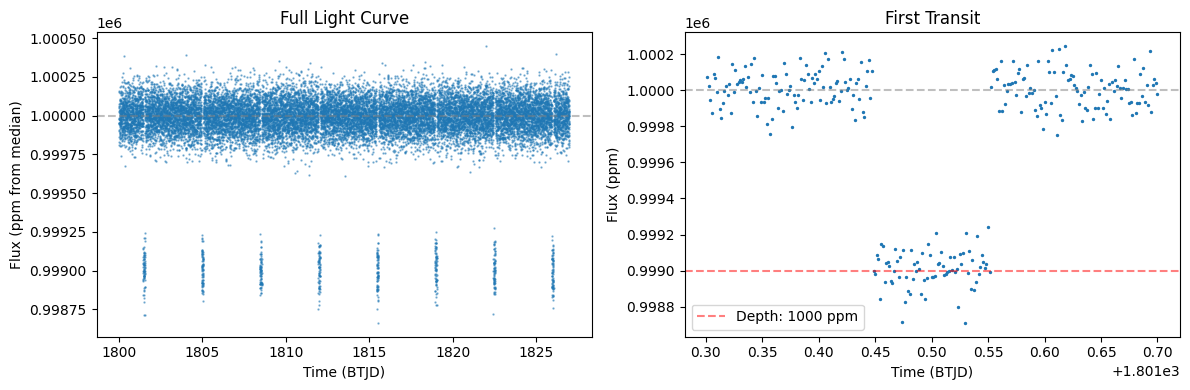

In [3]:
try:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Full light curve
    ax1.scatter(time, flux * 1e6, s=0.5, alpha=0.5)
    ax1.set_xlabel('Time (BTJD)')
    ax1.set_ylabel('Flux (ppm from median)')
    ax1.set_title('Full Light Curve')
    ax1.axhline(1e6, color='gray', linestyle='--', alpha=0.5)
    
    # Zoom on first transit
    transit_mask = (time > t0 - 0.2) & (time < t0 + 0.2)
    ax2.scatter(time[transit_mask], flux[transit_mask] * 1e6, s=2)
    ax2.axhline(1e6, color='gray', linestyle='--', alpha=0.5)
    ax2.axhline(1e6 - depth_ppm, color='red', linestyle='--', alpha=0.5, label=f'Depth: {depth_ppm} ppm')
    ax2.set_xlabel('Time (BTJD)')
    ax2.set_ylabel('Flux (ppm)')
    ax2.set_title('First Transit')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
except ImportError:
    print("matplotlib not installed - skipping visualization")

## Creating API Objects

Now we create the objects required by the vetting pipeline:

1. **`LightCurve`**: Container for time-series photometry
2. **`Ephemeris`**: Transit timing parameters (period, epoch, duration)
3. **`Candidate`**: Combines ephemeris with depth information

In [4]:
# Create LightCurve object
lc = LightCurve(
    time=time,
    flux=flux,
    flux_err=flux_err,
)

print(f"LightCurve created with {len(lc.time)} points")
print(f"  time shape: {lc.time.shape}")
print(f"  flux shape: {lc.flux.shape}")
print(f"  flux_err shape: {lc.flux_err.shape}")

LightCurve created with 19440 points
  time shape: (19440,)
  flux shape: (19440,)
  flux_err shape: (19440,)


In [5]:
# Create Ephemeris object
ephemeris = Ephemeris(
    period_days=period,        # Orbital period
    t0_btjd=t0,               # Reference transit epoch
    duration_hours=duration_hours,  # Transit duration
)

print(f"Ephemeris:")
print(f"  Period: {ephemeris.period_days} days")
print(f"  T0: BTJD {ephemeris.t0_btjd}")
print(f"  Duration: {ephemeris.duration_hours} hours")

Ephemeris:
  Period: 3.5 days
  T0: BTJD 1801.5
  Duration: 2.5 hours


In [6]:
# Create Candidate object
candidate = Candidate(
    ephemeris=ephemeris,
    depth_ppm=depth_ppm,  # You can also use depth_fraction=0.001
)

print(f"Candidate:")
print(f"  Period: {candidate.ephemeris.period_days} days")
print(f"  Depth: {candidate.depth_ppm} ppm ({candidate.depth:.4f} fractional)")

Candidate:
  Period: 3.5 days
  Depth: 1000 ppm (0.0010 fractional)


## Running the Vetting Pipeline

The `vet_candidate()` function runs a tiered vetting pipeline:

- **Tier 1 (LC-only, V01-V05)**: Always run, require only light curve
- **Tier 2 (Catalog, V06-V07)**: Run if `network=True` and coordinates provided
- **Tier 3 (Pixel, V08-V10)**: Run if TPF data provided
- **Tier 4 (Exovetter, V11-V12)**: Run if exovetter package available

For this tutorial, we run only LC-only checks with `network=False`:

In [7]:
# Run vetting pipeline (LC-only checks)
result = vet_candidate(
    lc, 
    candidate, 
    network=False,  # No external catalog queries
)

print(f"Vetting complete!")
print(f"  Checks executed: {len(result.results)}")
print(f"  Warnings: {len(result.warnings)}")

Vetting complete!
  Checks executed: 12
  Warnings: 5


## Understanding VettingBundleResult

The `vet_candidate()` function returns a `VettingBundleResult` containing:

- `results`: List of `CheckResult` objects
- `provenance`: Metadata about the run (versions, config, etc.)
- `warnings`: Any warnings generated during vetting

In [8]:
# Examine the result structure
print("VettingBundleResult summary:")
print(f"  n_ok: {result.n_passed}")
print(f"  n_skipped: {sum(1 for r in result.results if r.status == 'skipped')}")
print(f"  n_error: {sum(1 for r in result.results if r.status == 'error')}")
print(f"  all_ok: {all(r.status == 'ok' for r in result.results)}")
print()
print("Provenance:")
for key, value in result.provenance.items():
    print(f"  {key}: {value}")


VettingBundleResult summary:
  n_ok: 5
  n_skipped: 5
  n_error: 2
  all_ok: False

Provenance:
  pipeline_version: 0.1.0
  duration_ms: 56.56
  checks_requested: None
  checks_run: 12


## Examining Individual Check Results

Each check produces a `CheckResult` with:

- `id`: Check identifier (V01, V02, etc.)
- `name`: Human-readable name
- `status`: `ok`, `skipped`, or `error`
- `confidence`: Optional confidence score (0-1) for `ok` results
- `metrics`: Machine-readable metrics (JSON scalars)
- `flags`: Machine-readable flags (e.g. `SKIPPED:NO_TPF`)
- `notes`: Human-readable notes
- `provenance`: Minimal provenance (versions/parameters)
- `raw`: Optional unstructured payload for advanced use


In [9]:
# List all check results
print("Check Results Summary:")
print("-" * 60)
for r in result.results:
    print(f"{r.id} {r.name}:")
    print(f"    status: {r.status}")
    print(f"    confidence: {r.confidence}")
    if r.flags:
        print(f"    flags: {r.flags}")
    print()


Check Results Summary:
------------------------------------------------------------
V01 Odd-Even Depth:
    status: ok
    confidence: 0.7

V02 Secondary Eclipse:
    status: ok
    confidence: 0.85

V03 Duration Consistency:
    status: ok
    confidence: 0.2

V04 Depth Stability:
    status: ok
    confidence: 0.7

V05 V-Shape:
    status: ok
    confidence: 0.935

V06 Nearby EB Search:
    status: skipped
    confidence: None
    flags: ['SKIPPED:NETWORK_DISABLED']

V07 ExoFOP TOI Lookup:
    status: skipped
    confidence: None
    flags: ['SKIPPED:NETWORK_DISABLED']

V08 Centroid Shift:
    status: skipped
    confidence: None
    flags: ['SKIPPED:NO_TPF']

V09 Difference Image:
    status: skipped
    confidence: None
    flags: ['SKIPPED:NO_TPF']

V10 Aperture Dependence:
    status: skipped
    confidence: None
    flags: ['SKIPPED:NO_TPF']

V11 ModShift:
    status: error
    confidence: None
    flags: ['ERROR:AttributeError']

V12 SWEET:
    status: error
    confidence: Non

### Check Details

Let's examine the details from a specific check. The `odd_even_depth` check (V01) compares transit depths in odd vs even transits - a significant difference would indicate an eclipsing binary with twice the apparent period.

In [10]:
# Get a specific check result by ID
v01 = result.get_result("V01")

if v01:
    print(f"V01 - {v01.name}")
    print(f"Status: {v01.status}")
    print(f"Confidence: {v01.confidence}")
    if v01.flags:
        print(f"Flags: {v01.flags}")

    print("\nMetrics:")
    for key, value in v01.metrics.items():
        print(f"  {key}: {value}")

    if v01.notes:
        print("\nNotes:")
        for note in v01.notes:
            print(f"  - {note}")
else:
    print("V01 check not found in results")


V01 - Odd-Even Depth
Status: ok
Confidence: 0.7

Metrics:
  odd_depth: 0.000983
  even_depth: 0.001001
  depth_diff_sigma: 1.98
  n_odd_points: 300
  n_even_points: 300
  n_odd_transits: 4
  n_even_transits: 4
  depth_odd_ppm: 983.3
  depth_even_ppm: 1000.5
  depth_err_odd_ppm: 5.9
  depth_err_even_ppm: 6.4
  delta_ppm: -17.2
  delta_sigma: 1.98
  rel_diff: 0.017
  method: per_epoch_median


### Interpreting Confidence Scores

The `confidence` score indicates how confident the check is in its assessment:

- **High confidence (>0.8)**: The check has strong evidence for its conclusion
- **Medium confidence (0.5-0.8)**: Moderate evidence, may need additional data
- **Low confidence (<0.5)**: Weak evidence, result should be treated with caution

Note: this library returns *metrics-first* results. Interpretation and policy decisions (e.g., "this candidate passes/fails") are left to downstream applications or human review.

In [11]:
# Categorize checks by confidence (when provided)
with_conf = [r for r in result.results if r.confidence is not None]
no_conf = [r for r in result.results if r.confidence is None]

high_conf = [r for r in with_conf if r.confidence >= 0.8]
med_conf = [r for r in with_conf if 0.5 <= r.confidence < 0.8]
low_conf = [r for r in with_conf if r.confidence < 0.5]

print(f"High confidence checks ({len(high_conf)}):")
for r in high_conf:
    print(f"  {r.id} {r.name}: {r.confidence:.3f}")

print(f"\nMedium confidence checks ({len(med_conf)}):")
for r in med_conf:
    print(f"  {r.id} {r.name}: {r.confidence:.3f}")

print(f"\nLow confidence checks ({len(low_conf)}):")
for r in low_conf:
    print(f"  {r.id} {r.name}: {r.confidence:.3f}")

print(f"\nChecks without confidence ({len(no_conf)}):")
for r in no_conf:
    print(f"  {r.id} {r.name}: confidence=None")

High confidence checks (2):
  V02 Secondary Eclipse: 0.850
  V05 V-Shape: 0.935

Medium confidence checks (2):
  V01 Odd-Even Depth: 0.700
  V04 Depth Stability: 0.700

Low confidence checks (1):
  V03 Duration Consistency: 0.200

Checks without confidence (7):
  V06 Nearby EB Search: confidence=None
  V07 ExoFOP TOI Lookup: confidence=None
  V08 Centroid Shift: confidence=None
  V09 Difference Image: confidence=None
  V10 Aperture Dependence: confidence=None
  V11 ModShift: confidence=None
  V12 SWEET: confidence=None


## Running Specific Checks

You can run specific checks by passing the `enabled` parameter:

In [12]:
# Run only V01 and V02
result_subset = vet_candidate(
    lc,
    candidate,
    checks=["V01", "V02"],
    network=False,
)

print(f"Subset vetting complete!")
print(f"Checks requested: {result_subset.provenance['checks_requested']}")
print(f"Checks run: {result_subset.provenance['checks_run']}")

Subset vetting complete!
Checks requested: ['V01', 'V02']
Checks run: 2


## LC-Only Checks Reference

Here's what each LC-only check does:

| ID | Name | Purpose |
|---|---|---|
| V01 | odd_even_depth | Compare odd/even transit depths (EB detection) |
| V02 | secondary_eclipse | Search for secondary eclipse (EB detection) |
| V03 | duration_consistency | Check if duration matches stellar density |
| V04 | depth_stability | Check depth consistency across transits |
| V05 | v_shape | Distinguish U-shaped vs V-shaped transits |

## Common Mistakes and Solutions

### 1. Invalid Ephemeris Parameters

In [13]:
# This will raise an error - period must be positive
try:
    bad_eph = Ephemeris(
        period_days=-1.0,  # Invalid!
        t0_btjd=1800.0,
        duration_hours=2.0,
    )
except ValueError as e:
    print(f"Error caught: {e}")

Error caught: period_days must be positive, got -1.0


### 2. Mismatched Array Lengths

In [14]:
# This will raise an error - arrays must have same length
try:
    bad_lc = LightCurve(
        time=np.arange(100),
        flux=np.ones(50),  # Wrong length!
    )
    # The error occurs when converting to internal format
    bad_lc.to_internal()
except ValueError as e:
    print(f"Error caught: {e}")

Error caught: time and flux must have the same length, got 100 and 50


### 3. Inconsistent Depth Values

In [15]:
# This will raise an error - depth_ppm and depth_fraction must agree
try:
    bad_candidate = Candidate(
        ephemeris=ephemeris,
        depth_ppm=1000,
        depth_fraction=0.01,  # Should be 0.001 for 1000 ppm!
    )
except ValueError as e:
    print(f"Error caught: {e}")

Error caught: depth_ppm (1000) and depth_fraction (0.01) disagree by 900.0% (>1% tolerance)


## Next Steps

Now that you understand the basic vetting workflow, you can:

1. **Tutorial 02**: Learn to detect transits with periodograms
2. **Tutorial 03**: Explore pixel-level diagnostics
3. Apply vetting to real TESS data from MAST

For real data analysis, you would:
1. Download light curves using `lightkurve` or the MAST API
2. Run periodogram detection to find candidate signals
3. Apply vetting to validate the candidates

## Summary

In this tutorial, you learned:

- How to create `LightCurve`, `Ephemeris`, and `Candidate` objects
- How to run the vetting pipeline with `vet_candidate()`
- How to interpret `VettingBundleResult` and individual `CheckResult` objects
- The meaning of confidence scores in metrics-only mode
- How to run specific checks by ID

The key insight is that `bittr-tess-vetter` provides **measurements** (metrics), not **decisions** (pass/fail). This design allows you to apply your own policy decisions based on your science goals.